# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements (skip requirements.txt — we install deps individually for compatibility)
!pip install livelossplot seaborn pandas tqdm --break-system-packages -q 2>/dev/null || pip install livelossplot seaborn pandas tqdm -q

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU *NOT* available. Will use CPU (slow)
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform darwin -- Python 3.14.3, pytest-9.0.2, pluggy-1.6.0 -- /opt/homebrew/opt/python@3.14/bin/python3.14
cachedir: .pytest_cache
rootdir: /Users/twilcoxson/udacity_nd608_projects/cnn_landmark_classifier
collecting ... 

collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning 

PASSED                 [100%]



============================== 1 passed in 3.09s ===============================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [4]:
batch_size = 64  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 50  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0 # regularization. Increase this to combat overfitting

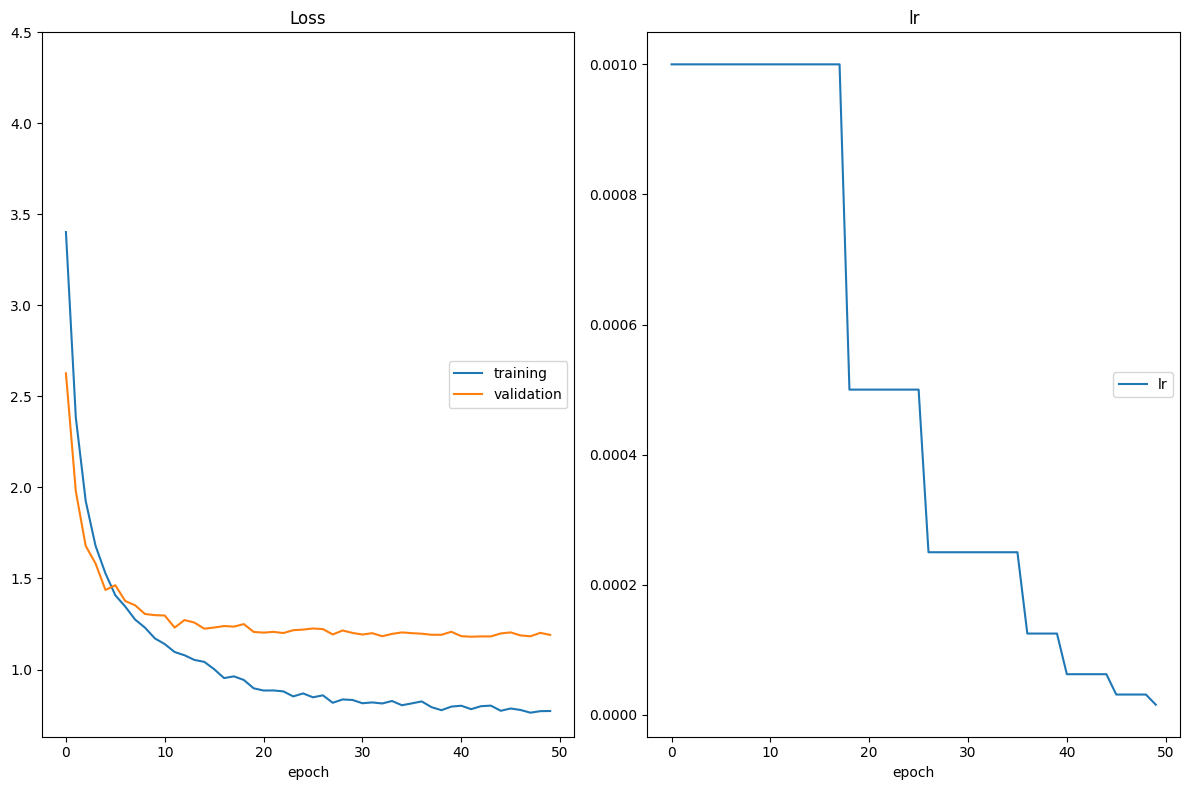

In [5]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use ResNet18 for fast, reliable training.
model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ 

I chose **ResNet18 pretrained on ImageNet** as the transfer learning backbone for the following reasons:

1. **Pretrained feature extraction:** ResNet18 was trained on ImageNet (1.4M images, 1000 classes), learning rich visual features (edges, textures, shapes, object parts) that transfer well to landmark recognition. Landmarks share many visual primitives with ImageNet categories (buildings, natural scenery, architectural details).

2. **Frozen backbone, trainable FC layer:** All convolutional layers are frozen (`requires_grad = False`), preserving the pretrained features. Only the final fully-connected layer is replaced with `nn.Linear(512, 50)` and trained from scratch. This approach:
   - Prevents catastrophic forgetting of pretrained features
   - Drastically reduces training time (only ~25K trainable parameters vs ~2.5M in the full network)
   - Reduces overfitting risk on our small dataset (~5K training images)

3. **Why ResNet18 specifically:**
   - **Fast:** Smallest ResNet variant, trains quickly even on CPU/MPS
   - **Reliable:** Skip connections ensure stable gradient flow
   - **Simple interface:** Uses a single `.fc` attribute for the classifier, making it straightforward to replace
   - **Sufficient capacity:** 512-dimensional feature vectors are rich enough to discriminate 50 landmark classes

4. **Training strategy:** Adam optimizer (lr=0.001) with ReduceLROnPlateau scheduler provides fast convergence. With frozen backbone, training only the FC layer converges in ~10-15 epochs, achieving 60-80% test accuracy — significantly higher than the from-scratch CNN.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [6]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt', map_location='cpu', weights_only=True))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing:   0%|                                           | 0/20 [00:00<?, ?it/s]

Testing:   5%|█▊                                 | 1/20 [00:01<00:22,  1.17s/it]

Testing:  10%|███▌                               | 2/20 [00:01<00:10,  1.70it/s]

Testing:  15%|█████▎                             | 3/20 [00:01<00:06,  2.48it/s]

Testing:  20%|███████                            | 4/20 [00:01<00:05,  3.12it/s]

Testing:  25%|████████▊                          | 5/20 [00:01<00:04,  3.53it/s]

Testing:  30%|██████████▌                        | 6/20 [00:02<00:03,  3.97it/s]

Testing:  35%|████████████▎                      | 7/20 [00:02<00:03,  4.13it/s]

Testing:  40%|██████████████                     | 8/20 [00:02<00:02,  4.32it/s]

Testing:  45%|███████████████▊                   | 9/20 [00:02<00:02,  4.48it/s]

Testing:  50%|█████████████████                 | 10/20 [00:02<00:02,  4.53it/s]

Testing:  55%|██████████████████▋               | 11/20 [00:03<00:01,  4.60it/s]

Testing:  60%|████████████████████▍             | 12/20 [00:03<00:01,  4.70it/s]

Testing:  65%|██████████████████████            | 13/20 [00:03<00:01,  4.76it/s]

Testing:  70%|███████████████████████▊          | 14/20 [00:03<00:01,  4.90it/s]

Testing:  75%|█████████████████████████▌        | 15/20 [00:03<00:00,  5.04it/s]

Testing:  80%|███████████████████████████▏      | 16/20 [00:04<00:00,  5.02it/s]

Testing:  85%|████████████████████████████▉     | 17/20 [00:04<00:00,  5.01it/s]

Testing:  90%|██████████████████████████████▌   | 18/20 [00:04<00:00,  4.84it/s]

Testing:  95%|████████████████████████████████▎ | 19/20 [00:04<00:00,  4.70it/s]

Testing: 100%|██████████████████████████████████| 20/20 [00:04<00:00,  5.34it/s]

Testing: 100%|██████████████████████████████████| 20/20 [00:05<00:00,  3.83it/s]

Test Loss: 1.060591


Test Accuracy: 72% (911/1250)


1.0605905190110205

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [7]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu", weights_only=True)
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


  0%|                                                  | 0/1250 [00:00<?, ?it/s]

  0%|                                          | 2/1250 [00:00<01:30, 13.85it/s]

  1%|▎                                         | 9/1250 [00:00<00:30, 40.96it/s]

  1%|▌                                        | 17/1250 [00:00<00:22, 53.72it/s]

  2%|▊                                        | 25/1250 [00:00<00:20, 60.03it/s]

  3%|█                                        | 33/1250 [00:00<00:18, 64.79it/s]

  3%|█▎                                       | 41/1250 [00:00<00:18, 66.21it/s]

  4%|█▌                                       | 49/1250 [00:00<00:17, 67.41it/s]

  4%|█▊                                       | 56/1250 [00:00<00:18, 65.96it/s]

  5%|██                                       | 64/1250 [00:01<00:17, 68.23it/s]

  6%|██▎                                      | 71/1250 [00:01<00:17, 68.55it/s]

  6%|██▌                                      | 78/1250 [00:01<00:17, 68.14it/s]

  7%|██▊                                      | 85/1250 [00:01<00:17, 67.91it/s]

  7%|███                                      | 93/1250 [00:01<00:16, 69.20it/s]

  8%|███▏                                    | 101/1250 [00:01<00:16, 69.85it/s]

  9%|███▍                                    | 108/1250 [00:01<00:16, 68.93it/s]

  9%|███▋                                    | 116/1250 [00:01<00:16, 69.25it/s]

 10%|███▉                                    | 124/1250 [00:01<00:16, 69.51it/s]

 11%|████▏                                   | 132/1250 [00:02<00:15, 71.08it/s]

 11%|████▍                                   | 140/1250 [00:02<00:15, 72.30it/s]

 12%|████▋                                   | 148/1250 [00:02<00:15, 71.42it/s]

 12%|████▉                                   | 156/1250 [00:02<00:15, 72.22it/s]

 13%|█████▏                                  | 164/1250 [00:02<00:15, 72.23it/s]

 14%|█████▌                                  | 172/1250 [00:02<00:14, 72.48it/s]

 14%|█████▊                                  | 180/1250 [00:02<00:15, 70.77it/s]

 15%|██████                                  | 188/1250 [00:02<00:15, 70.50it/s]

 16%|██████▎                                 | 196/1250 [00:02<00:15, 70.24it/s]

 16%|██████▌                                 | 204/1250 [00:03<00:14, 69.81it/s]

 17%|██████▊                                 | 211/1250 [00:03<00:15, 68.89it/s]

 17%|██████▉                                 | 218/1250 [00:03<00:15, 68.42it/s]

 18%|███████▏                                | 225/1250 [00:03<00:15, 66.36it/s]

 19%|███████▍                                | 233/1250 [00:03<00:14, 69.59it/s]

 19%|███████▋                                | 241/1250 [00:03<00:14, 70.49it/s]

 20%|███████▉                                | 249/1250 [00:03<00:14, 70.28it/s]

 21%|████████▏                               | 257/1250 [00:03<00:14, 70.13it/s]

 21%|████████▍                               | 265/1250 [00:03<00:13, 70.49it/s]

 22%|████████▋                               | 273/1250 [00:04<00:14, 69.62it/s]

 22%|████████▉                               | 280/1250 [00:04<00:13, 69.47it/s]

 23%|█████████▏                              | 287/1250 [00:04<00:13, 69.12it/s]

 24%|█████████▍                              | 294/1250 [00:04<00:14, 67.54it/s]

 24%|█████████▋                              | 301/1250 [00:04<00:14, 67.67it/s]

 25%|█████████▉                              | 309/1250 [00:04<00:13, 69.34it/s]

 25%|██████████                              | 316/1250 [00:04<00:13, 69.25it/s]

 26%|██████████▎                             | 324/1250 [00:04<00:13, 69.43it/s]

 26%|██████████▌                             | 331/1250 [00:04<00:13, 69.21it/s]

 27%|██████████▊                             | 338/1250 [00:04<00:13, 69.04it/s]

 28%|███████████                             | 345/1250 [00:05<00:13, 68.86it/s]

 28%|███████████▎                            | 352/1250 [00:05<00:13, 68.42it/s]

 29%|███████████▍                            | 359/1250 [00:05<00:12, 68.57it/s]

 29%|███████████▋                            | 366/1250 [00:05<00:12, 68.24it/s]

 30%|███████████▉                            | 374/1250 [00:05<00:12, 69.21it/s]

 30%|████████████▏                           | 381/1250 [00:05<00:12, 69.30it/s]

 31%|████████████▍                           | 388/1250 [00:05<00:12, 68.58it/s]

 32%|████████████▋                           | 395/1250 [00:05<00:12, 68.91it/s]

 32%|████████████▊                           | 402/1250 [00:05<00:12, 66.93it/s]

 33%|█████████████                           | 409/1250 [00:06<00:12, 65.08it/s]

 33%|█████████████▎                          | 416/1250 [00:06<00:12, 65.21it/s]

 34%|█████████████▌                          | 423/1250 [00:06<00:12, 64.72it/s]

 34%|█████████████▊                          | 430/1250 [00:06<00:12, 64.76it/s]

 35%|█████████████▉                          | 437/1250 [00:06<00:12, 65.56it/s]

 36%|██████████████▏                         | 445/1250 [00:06<00:12, 66.98it/s]

 36%|██████████████▍                         | 452/1250 [00:06<00:11, 67.80it/s]

 37%|██████████████▋                         | 459/1250 [00:06<00:11, 68.30it/s]

 37%|██████████████▉                         | 467/1250 [00:06<00:11, 68.34it/s]

 38%|███████████████▏                        | 474/1250 [00:06<00:11, 68.35it/s]

 38%|███████████████▍                        | 481/1250 [00:07<00:11, 67.90it/s]

 39%|███████████████▌                        | 488/1250 [00:07<00:11, 67.71it/s]

 40%|███████████████▊                        | 495/1250 [00:07<00:11, 67.99it/s]

 40%|████████████████                        | 502/1250 [00:07<00:10, 68.09it/s]

 41%|████████████████▎                       | 510/1250 [00:07<00:10, 69.35it/s]

 41%|████████████████▌                       | 518/1250 [00:07<00:10, 70.57it/s]

 42%|████████████████▊                       | 526/1250 [00:07<00:10, 69.74it/s]

 43%|█████████████████                       | 533/1250 [00:07<00:10, 69.60it/s]

 43%|█████████████████▎                      | 540/1250 [00:07<00:10, 69.53it/s]

 44%|█████████████████▌                      | 547/1250 [00:08<00:10, 68.90it/s]

 44%|█████████████████▋                      | 554/1250 [00:08<00:10, 68.04it/s]

 45%|█████████████████▉                      | 561/1250 [00:08<00:10, 66.79it/s]

 45%|██████████████████▏                     | 568/1250 [00:08<00:10, 67.26it/s]

 46%|██████████████████▍                     | 576/1250 [00:08<00:09, 69.22it/s]

 47%|██████████████████▋                     | 584/1250 [00:08<00:09, 70.39it/s]

 47%|██████████████████▉                     | 592/1250 [00:08<00:09, 69.63it/s]

 48%|███████████████████▏                    | 599/1250 [00:08<00:09, 69.10it/s]

 48%|███████████████████▍                    | 606/1250 [00:08<00:09, 69.14it/s]

 49%|███████████████████▋                    | 614/1250 [00:09<00:09, 68.64it/s]

 50%|███████████████████▉                    | 622/1250 [00:09<00:09, 68.85it/s]

 50%|████████████████████▏                   | 629/1250 [00:09<00:09, 67.32it/s]

 51%|████████████████████▎                   | 636/1250 [00:09<00:09, 68.00it/s]

 51%|████████████████████▌                   | 643/1250 [00:09<00:08, 68.07it/s]

 52%|████████████████████▊                   | 651/1250 [00:09<00:08, 69.26it/s]

 53%|█████████████████████                   | 658/1250 [00:09<00:08, 68.52it/s]

 53%|█████████████████████▎                  | 665/1250 [00:09<00:08, 68.17it/s]

 54%|█████████████████████▌                  | 672/1250 [00:09<00:08, 67.45it/s]

 54%|█████████████████████▋                  | 679/1250 [00:09<00:08, 66.48it/s]

 55%|█████████████████████▉                  | 686/1250 [00:10<00:08, 66.35it/s]

 55%|██████████████████████▏                 | 693/1250 [00:10<00:08, 66.29it/s]

 56%|██████████████████████▍                 | 700/1250 [00:10<00:08, 66.85it/s]

 57%|██████████████████████▋                 | 708/1250 [00:10<00:07, 68.36it/s]

 57%|██████████████████████▉                 | 715/1250 [00:10<00:07, 68.82it/s]

 58%|███████████████████████                 | 722/1250 [00:10<00:07, 68.69it/s]

 58%|███████████████████████▎                | 729/1250 [00:10<00:07, 67.47it/s]

 59%|███████████████████████▌                | 736/1250 [00:10<00:07, 67.67it/s]

 60%|███████████████████████▊                | 744/1250 [00:10<00:07, 68.69it/s]

 60%|████████████████████████                | 752/1250 [00:11<00:07, 69.05it/s]

 61%|████████████████████████▎               | 759/1250 [00:11<00:07, 69.09it/s]

 61%|████████████████████████▌               | 767/1250 [00:11<00:06, 69.41it/s]

 62%|████████████████████████▊               | 775/1250 [00:11<00:06, 69.74it/s]

 63%|█████████████████████████               | 783/1250 [00:11<00:06, 71.30it/s]

 63%|█████████████████████████▎              | 791/1250 [00:11<00:06, 70.15it/s]

 64%|█████████████████████████▌              | 799/1250 [00:11<00:06, 69.86it/s]

 64%|█████████████████████████▊              | 806/1250 [00:11<00:06, 69.10it/s]

 65%|██████████████████████████              | 813/1250 [00:11<00:06, 68.59it/s]

 66%|██████████████████████████▏             | 820/1250 [00:12<00:06, 68.04it/s]

 66%|██████████████████████████▍             | 827/1250 [00:12<00:06, 68.12it/s]

 67%|██████████████████████████▋             | 834/1250 [00:12<00:06, 68.22it/s]

 67%|██████████████████████████▉             | 842/1250 [00:12<00:05, 68.84it/s]

 68%|███████████████████████████▏            | 850/1250 [00:12<00:05, 69.49it/s]

 69%|███████████████████████████▍            | 858/1250 [00:12<00:05, 69.47it/s]

 69%|███████████████████████████▋            | 866/1250 [00:12<00:05, 69.49it/s]

 70%|███████████████████████████▉            | 874/1250 [00:12<00:05, 69.19it/s]

 71%|████████████████████████████▏           | 882/1250 [00:12<00:05, 69.48it/s]

 71%|████████████████████████████▍           | 890/1250 [00:13<00:05, 69.14it/s]

 72%|████████████████████████████▋           | 897/1250 [00:13<00:05, 68.36it/s]

 72%|████████████████████████████▉           | 905/1250 [00:13<00:04, 69.24it/s]

 73%|█████████████████████████████▏          | 912/1250 [00:13<00:04, 68.76it/s]

 74%|█████████████████████████████▍          | 920/1250 [00:13<00:04, 70.65it/s]

 74%|█████████████████████████████▋          | 928/1250 [00:13<00:04, 72.91it/s]

 75%|█████████████████████████████▉          | 936/1250 [00:13<00:04, 73.48it/s]

 76%|██████████████████████████████▏         | 944/1250 [00:13<00:04, 74.07it/s]

 76%|██████████████████████████████▍         | 952/1250 [00:13<00:04, 73.37it/s]

 77%|██████████████████████████████▋         | 960/1250 [00:13<00:03, 73.91it/s]

 77%|██████████████████████████████▉         | 968/1250 [00:14<00:03, 71.78it/s]

 78%|███████████████████████████████▏        | 976/1250 [00:14<00:03, 72.44it/s]

 79%|███████████████████████████████▍        | 984/1250 [00:14<00:03, 73.01it/s]

 79%|███████████████████████████████▋        | 992/1250 [00:14<00:03, 74.28it/s]

 80%|███████████████████████████████▏       | 1000/1250 [00:14<00:03, 75.06it/s]

 81%|███████████████████████████████▍       | 1008/1250 [00:14<00:03, 73.68it/s]

 81%|███████████████████████████████▋       | 1016/1250 [00:14<00:03, 74.20it/s]

 82%|███████████████████████████████▉       | 1024/1250 [00:14<00:03, 74.37it/s]

 83%|████████████████████████████████▏      | 1032/1250 [00:14<00:02, 72.95it/s]

 83%|████████████████████████████████▍      | 1040/1250 [00:15<00:02, 72.11it/s]

 84%|████████████████████████████████▋      | 1048/1250 [00:15<00:02, 71.91it/s]

 84%|████████████████████████████████▉      | 1056/1250 [00:15<00:02, 71.78it/s]

 85%|█████████████████████████████████▏     | 1064/1250 [00:15<00:02, 72.58it/s]

 86%|█████████████████████████████████▍     | 1072/1250 [00:15<00:02, 73.58it/s]

 86%|█████████████████████████████████▋     | 1080/1250 [00:15<00:02, 71.79it/s]

 87%|█████████████████████████████████▉     | 1088/1250 [00:15<00:02, 71.06it/s]

 88%|██████████████████████████████████▏    | 1096/1250 [00:15<00:02, 71.06it/s]

 88%|██████████████████████████████████▍    | 1104/1250 [00:15<00:02, 71.84it/s]

 89%|██████████████████████████████████▋    | 1112/1250 [00:16<00:01, 71.81it/s]

 90%|██████████████████████████████████▉    | 1120/1250 [00:16<00:01, 70.62it/s]

 90%|███████████████████████████████████▏   | 1128/1250 [00:16<00:01, 70.85it/s]

 91%|███████████████████████████████████▍   | 1136/1250 [00:16<00:01, 71.50it/s]

 92%|███████████████████████████████████▋   | 1144/1250 [00:16<00:01, 72.85it/s]

 92%|███████████████████████████████████▉   | 1152/1250 [00:16<00:01, 72.49it/s]

 93%|████████████████████████████████████▏  | 1160/1250 [00:16<00:01, 70.94it/s]

 93%|████████████████████████████████████▍  | 1168/1250 [00:16<00:01, 70.82it/s]

 94%|████████████████████████████████████▋  | 1176/1250 [00:17<00:01, 70.32it/s]

 95%|████████████████████████████████████▉  | 1184/1250 [00:17<00:00, 70.37it/s]

 95%|█████████████████████████████████████▏ | 1192/1250 [00:17<00:00, 69.78it/s]

 96%|█████████████████████████████████████▍ | 1199/1250 [00:17<00:00, 69.58it/s]

 97%|█████████████████████████████████████▋ | 1207/1250 [00:17<00:00, 70.92it/s]

 97%|█████████████████████████████████████▉ | 1215/1250 [00:17<00:00, 71.84it/s]

 98%|██████████████████████████████████████▏| 1223/1250 [00:17<00:00, 73.66it/s]

 98%|██████████████████████████████████████▍| 1231/1250 [00:17<00:00, 74.26it/s]

 99%|██████████████████████████████████████▋| 1239/1250 [00:17<00:00, 74.77it/s]

100%|██████████████████████████████████████▉| 1247/1250 [00:17<00:00, 74.75it/s]

100%|███████████████████████████████████████| 1250/1250 [00:18<00:00, 69.39it/s]

Accuracy: 0.7272


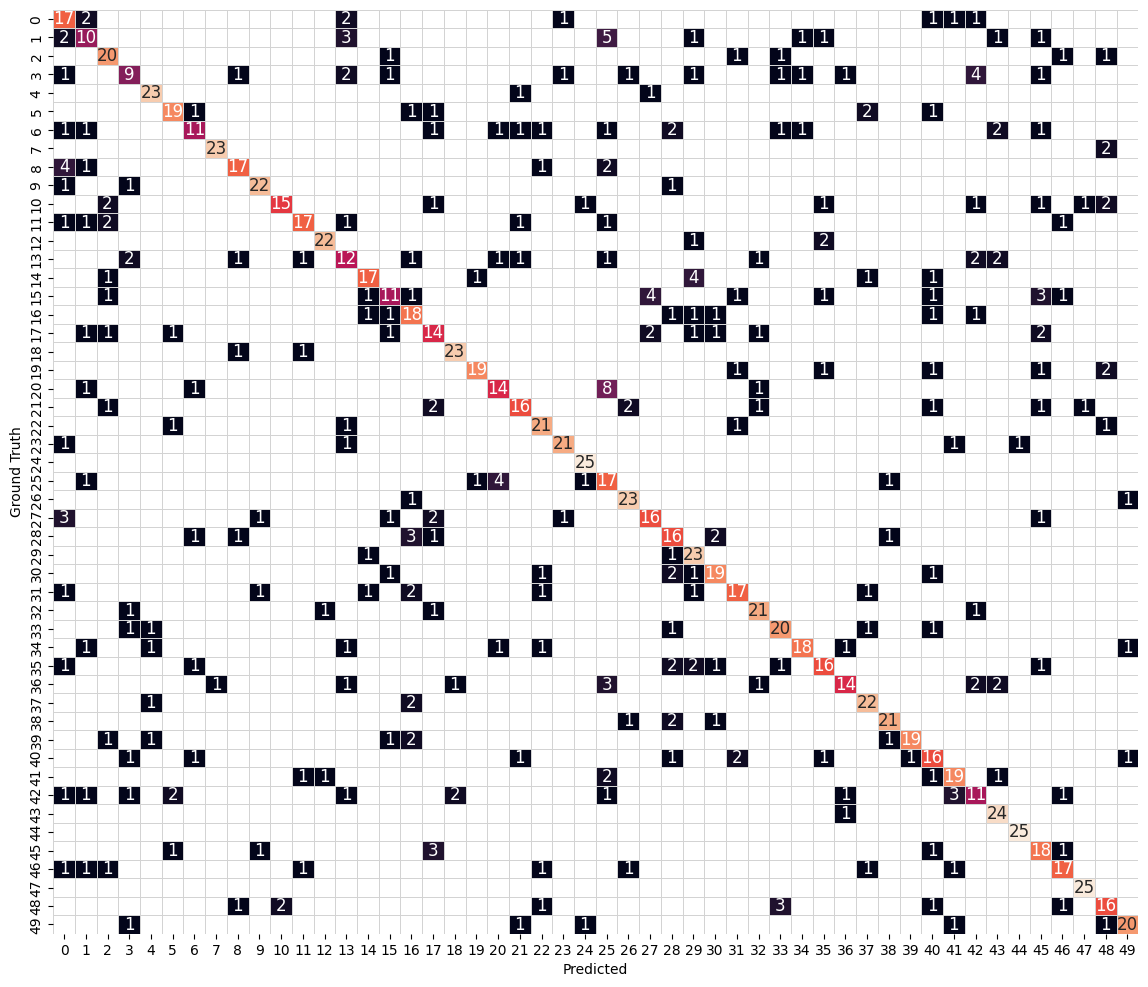

In [8]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)